# install 및 import

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, Subset

from PIL import Image, ImageDraw, ImageFont, ImageChops, ImageEnhance
import cv2
from skimage import io

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from timm import create_model
from timm.data.loader import *
from timm.optim import *

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

import os

from IPython.display import display

from collections import defaultdict

import pandas as pd

import csv

In [ ]:
import warnings

warnings.filterwarnings(action='ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 함수 정의

In [ ]:
class SampledImageFolder(Dataset):
    def __init__(self, root, transform=None, sample_per_class=10):
        self.root = root
        self.transform = transform
        self.sample_per_class = sample_per_class

        self.classes = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
        self.class_to_idx = {self.classes[i]: i for i in range(len(self.classes))}

        self.samples, self.class_counts = self._make_dataset()

    def _make_dataset(self):
        samples = []
        class_counts = {class_name: 0 for class_name in self.classes}  # 각 클래스별 샘플 수를 저장할 딕셔너리
        for class_name in self.classes:
            class_dir = os.path.join(self.root, class_name)
            if not os.path.isdir(class_dir):
                continue
            for root, _, fnames in sorted(os.walk(class_dir)):
                random.shuffle(fnames)
                for i, fname in enumerate(fnames):
                    if i >= self.sample_per_class:
                        break
                    path = os.path.join(root, fname)
                    item = (path, self.class_to_idx[class_name])
                    samples.append(item)
                    class_counts[class_name] += 1  # 클래스별 샘플 수 증가
        return samples, class_counts  # 샘플 리스트와 클래스별 샘플 수 반환

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, target = self.samples[index]
        image = Image.open(path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, target

In [ ]:
def data_preprocessing(data_dir, batch_size, sample_per_class=10, sampling=True):
    if sampling==True:
      data_transforms = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

      dataset = SampledImageFolder(root=data_dir, transform=data_transforms, sample_per_class=sample_per_class)

      dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

      class_names = dataset.classes
      num_classes = len(class_names)

      print("클래스 수:", num_classes)
      print("클래스 리스트:", class_names)

      class_counts = dataset.class_counts  # 클래스별 샘플 수를 가져옴
      print("클래스별 데이터 갯수:")
      for class_name, count in class_counts.items():
          print(f"{class_name}: {count} 개")

      return dataset, dataloader

    else:
      # 데이터 전처리 및 변환
      data_transforms = transforms.Compose([
          transforms.Resize((224, 224)),  # 이미지 크기 조정 (필요에 따라 조절)
          transforms.ToTensor(),  # 이미지를 Tensor로 변환
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 이미지 정규화 (필요에 따라 조절)
      ])

      # ImageFolder 데이터셋 생성
      dataset = ImageFolder(root=data_dir, transform=data_transforms)

      # 데이터 로더 생성
      # batch_size = 32  # 필요에 따라 조절
      dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

      # 데이터셋의 클래스(라벨) 정보
      class_names = dataset.classes
      num_classes = len(class_names)

      class_counts = defaultdict(int)
      for _, label in dataset.samples:
          class_counts[class_names[label]] += 1

      # 클래스(라벨) 정보 출력
      print("클래스 수:", num_classes)
      print("클래스 리스트:", class_names)
      print("각 클래스별 데이터 갯수:")
      for class_name, count in class_counts.items():
          print(f"{class_name}: {count}개")

      return dataset, dataloader

In [ ]:
def model_setting(model_name, output_path, dataset, dataloader, epochs=10, load_model=False):

  model = create_model(model_name, pretrained=False)

  num_classes = len(dataset.classes)

  last_layer_name = None
  for name, module in model.named_modules():
    if isinstance(module, nn.Linear):
        last_layer_name = name
        last_layer_features = module.in_features

  new_last_layer = nn.Linear(last_layer_features, num_classes)

  setattr(model, last_layer_name, new_last_layer)

  if load_model==True:
    state_path=None
    for state_name in os.listdir(output_path):
      if model_name in state_name:
        state_path = os.path.join(output_path, state_name)
        model.load_state_dict(torch.load(state_path))
        print('Load state success')
    if state_path==None:
      raise Exception('state_path is None')

  # 손실 함수 및 옵티마이저 설정
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  # 학습 루프
  num_epochs = epochs
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  print(f'Start train {model_name}')

  best_accuracy = 0.0  # 초기 최고 정확도를 0.0으로 설정
  best_model_path = output_path + f'/{model_name}_best_model.pth'  # 최고 정확도를 가진 모델을 저장할 경로

  acc_log = []
  loss_log = []

  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      predictions = []  # 예측값 저장
      ground_truth = []  # 실제 라벨 저장

      for inputs, labels in dataloader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          # 에폭마다 예측값과 실제 라벨을 저장
          _, preds = torch.max(outputs, 1)
          predictions.extend(preds.cpu().numpy())
          ground_truth.extend(labels.cpu().numpy())

      # 정확도 계산
      acc = accuracy_score(ground_truth, predictions)

      acc_log.append(acc)
      loss_log.append(running_loss / len(dataloader))

      print(f'{model_name} - Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(dataloader)}, Accuracy: {acc}')

      # 현재 에폭의 정확도가 최고 정확도보다 높으면 모델을 저장
      if acc > best_accuracy:
          best_accuracy = acc
          torch.save(model.state_dict(), best_model_path)

  print('Finished Training')

  return model, acc_log, loss_log

In [ ]:
def train_all_model(model_list, data_dir, output_path, sample_per_class=100, batch_size=32, epochs=10, load_model=False, sampling=True):
  acc_log = {}
  loss_log = {}
  models = {}

  dataset, dataloader = data_preprocessing(data_dir, batch_size, sample_per_class, sampling=sampling)

  for model_name in model_list:
    model, acc_log_v, loss_log_v = model_setting(model_name, output_path, dataset, dataloader, epochs, load_model=load_model)
    acc_log[model_name] = acc_log_v
    with open(output_path + f'/{model_name}_acc_log.csv', 'w') as file:
      writer = csv.writer(file)
      writer.writerow(acc_log_v)
    loss_log[model_name] = loss_log_v
    with open(output_path + f'/{model_name}_loss_log.csv', 'w') as file:
      writer = csv.writer(file)
      writer.writerow(loss_log_v)
    models[model_name] = model

  return models, acc_log, loss_log

In [ ]:
def imshow_normalized(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)  # [0, 1] 범위 내로 클리핑
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def data_checking(dataset, dataloader, sample_len):
  class_data = {class_name: [] for class_name in dataset.classes}

  for data in dataloader:
    inputs, labels = data
    for i in range(len(inputs)):
        class_name = dataset.classes[labels[i]]
        class_data[class_name].append(inputs[i])

  for class_name, data_list in class_data.items():
    check_len = min(len(data_list), sample_len)
    num_samples = check_len
    num_columns = 5  # 한 행에 표시할 이미지 수
    num_rows = (num_samples + num_columns - 1) // num_columns

    plt.figure(figsize=(15, 3 * num_rows))
    plt.suptitle(f"Class: {class_name} ({num_samples} samples)")

    for i in range(num_samples):
        plt.subplot(num_rows, num_columns, i + 1)
        imshow_normalized(data_list[i])
        plt.axis('off')

    plt.show()

In [ ]:
def visualization_log(metrics_log, dataset_name, if_loss=True):
  if if_loss==True:
    y_lab = 'Loss'
  else:
    y_lab = 'Acc'

  plt.figure(figsize=(10, 6))

  for model_name, acc_list in metrics_log.items():
      epochs = range(1, len(acc_list) + 1)
      plt.plot(epochs, acc_list, label=model_name)

  plt.xlabel('Epochs')
  plt.ylabel(y_lab)
  plt.title(f'{dataset_name} : {y_lab} per Epochs')
  plt.legend(loc='lower right')

  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [ ]:
def preprocessing_to_predict(preprocessing_type, target_image):
  try:
    if not os.path.exists('/temp'):
        os.makedirs('/temp')
  except OSError:
    print ('Error: Creating directory')
  tmp_fname = '/temp/' + target_image.split('/')[-1]



  if preprocessing_type == 'grayscale':
    image = cv2.imread(target_image, cv2.IMREAD_GRAYSCALE) # 흑백 이미지로 로드
    cv2.imwrite(tmp_fname, image)
    output_img = Image.open(tmp_fname)

    os.remove(tmp_fname)
    return output_img



  elif preprocessing_type == 'sharpening':
    strength = 17

    image = io.imread(target_image)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    b = (1 - strength) / 8
    sharpening_kernel = np.array([[b, b, b], [b, strength, b], [b, b, b]])
    output = cv2.filter2D(image, -1, sharpening_kernel)

    cv2.imwrite(tmp_fname, output)
    output_img = Image.open(tmp_fname)

    os.remove(tmp_fname)
    return output_img



  elif preprocessing_type == 'canny':
    image_gray = cv2.imread(target_image, cv2.IMREAD_GRAYSCALE) # 흑백 이미지로 로드
    median_intensity = np.median(image_gray) # 픽셀 강도의 중간값을 계산

    lower_threshold = int(max(0, (1.0 - 0.33) * median_intensity))
    upper_threshold = int(min(255, (1.0 + 0.33) * median_intensity))

    image_canny = cv2.Canny(image_gray, lower_threshold, upper_threshold)

    cv2.imwrite(tmp_fname, image_canny)
    output_img = Image.open(tmp_fname)

    os.remove(tmp_fname)
    return output_img



  elif preprocessing_type == 'diffusion':
    image = cv2.imread(target_image)

    noise_level = 10
    start_step = 1
    end_step = 10

    noisy_image = image.copy()

    for step in range(start_step, end_step + 4):
        current_noise_level = noise_level * step

        noise = np.random.normal(0, current_noise_level, image.shape).astype('int16')

        noisy_image = cv2.add(noisy_image, noise, dtype=cv2.CV_8U)

        noisy_image = np.clip(noisy_image, 0, 255).astype('uint8')

    cv2.imwrite(tmp_fname, noisy_image)
    output_img = Image.open(tmp_fname)

    os.remove(tmp_fname)
    return output_img



  elif preprocessing_type == 'ela':
    quality = 90

    ori_im = Image.open(target_image)
    ori_im.save(tmp_fname, 'JPEG', quality=quality)

    tmp_fname_im = Image.open(tmp_fname)
    ela_im = ImageChops.difference(ori_im, tmp_fname_im)

    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0/max_diff
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)

    os.remove(tmp_fname)
    return ela_im

In [ ]:
def predict_by_model(model, target_image, target_type, label=None, is_list=False, is_visualization=True):
  if is_list==True:
    if label==None:
      raise Exception('label을 지정해주세요')

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  if is_list==False:
    image_path = target_image
    image = preprocessing_to_predict(target_type, image_path)
    input_tensor = transform(image).unsqueeze(0).to(device)

    model.eval().to(device)
    with torch.no_grad():
      output = model(input_tensor)

    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    predicted_class = torch.argmax(probabilities).item()

    if is_visualization==True:
      display(image)

    print(f'Predicted class index: {predicted_class}')
    print(f'Predicted class probability: {probabilities[predicted_class].item()}')

  else:
    folder_path = target_image
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

    model.eval().to(device)

    output_list = []

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        image = preprocessing_to_predict(target_type, image_path)
        input_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)

        probabilities = torch.nn.functional.softmax(output[0], dim=0)

        predicted_class = torch.argmax(probabilities).item()

        if is_visualization==True:
          display(image)
        print(f'Image: {image_file}, Predicted class index: {predicted_class}')
        print(f'Predicted class probability: {probabilities[predicted_class].item()}')
        print('---------------')

        output_list.append([image_file, label, predicted_class, image_path])
    return output_list

# 실제 코드 실행

## 모델 리스트

In [ ]:
# 학습가능한 모델리스트
# filter를 통해 검색가능
timm.list_models(filter='')

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

## 파라미터 셋팅

In [ ]:
# 전처리부터 모델링까지 한번에

# model_list에 model명 넣기
model_list = ['vit_base_patch16_224', 'resnet50', 'coatnet_rmlp_nano_rw_224', 'efficientnet_b0']

input_dir = '/content/drive/MyDrive/풍경모델/풍경전처리'

output_dir = '/content/drive/MyDrive/풍경모델/풍경전처리'

# 샘플링할 데이터 갯수 (각각 몇개씩)
sample_per_class = 5

batch_size = 64

epochs = 10

# 만약 저장된 가중치를 불러오고 싶으면 load_model=True로 변경
# True로 변경하게되면 model명과 가중치저장경로를 통해 가중치를 가져옴
load_model=False

sampling=False

## dataloader 정상 작동 확인용

In [ ]:
dataset, dataloader = data_preprocessing(input_dir, batch_size, 10, False)

클래스 수: 2
클래스 리스트: ['ai_landscape', 'real_landscape']
각 클래스별 데이터 갯수:
ai_landscape: 3497개
real_landscape: 4925개


## 모델 학습

In [ ]:
# train_all_model(모델리스트, 학습이미지경로, 가중치저장경로)
# models에는 모델이 dict형태로 저장 / train_log에는 accuracy가 dict형태로 저장
models, acc_log, loss_log = train_all_model(model_list, input_dir, output_dir, sample_per_class=sample_per_class, batch_size=batch_size,
                                    epochs=epochs, load_model=load_model, sampling=sampling)

클래스 수: 2
클래스 리스트: ['ai_landscape', 'real_landscape']
각 클래스별 데이터 갯수:
ai_landscape: 3497개
real_landscape: 4925개
Start train vit_base_patch16_224
vit_base_patch16_224 - Epoch 1/10, Loss: 0.8504892280607512, Accuracy: 0.5654238898123961
vit_base_patch16_224 - Epoch 2/10, Loss: 0.6470171804680969, Accuracy: 0.60710045119924
vit_base_patch16_224 - Epoch 3/10, Loss: 0.5697044079953973, Accuracy: 0.6871289479933508
vit_base_patch16_224 - Epoch 4/10, Loss: 0.6206152633284078, Accuracy: 0.6376157682260746
vit_base_patch16_224 - Epoch 5/10, Loss: 0.57757953080264, Accuracy: 0.6699121348848255
vit_base_patch16_224 - Epoch 6/10, Loss: 0.5153870207793785, Accuracy: 0.7274994063167893
vit_base_patch16_224 - Epoch 7/10, Loss: 0.5164754336530512, Accuracy: 0.727143196390406
vit_base_patch16_224 - Epoch 8/10, Loss: 0.58692106469111, Accuracy: 0.6713369745903586
vit_base_patch16_224 - Epoch 9/10, Loss: 0.6454663872718811, Accuracy: 0.6136309665162669
vit_base_patch16_224 - Epoch 10/10, Loss: 0.6497885720

## 시각화 및 예측

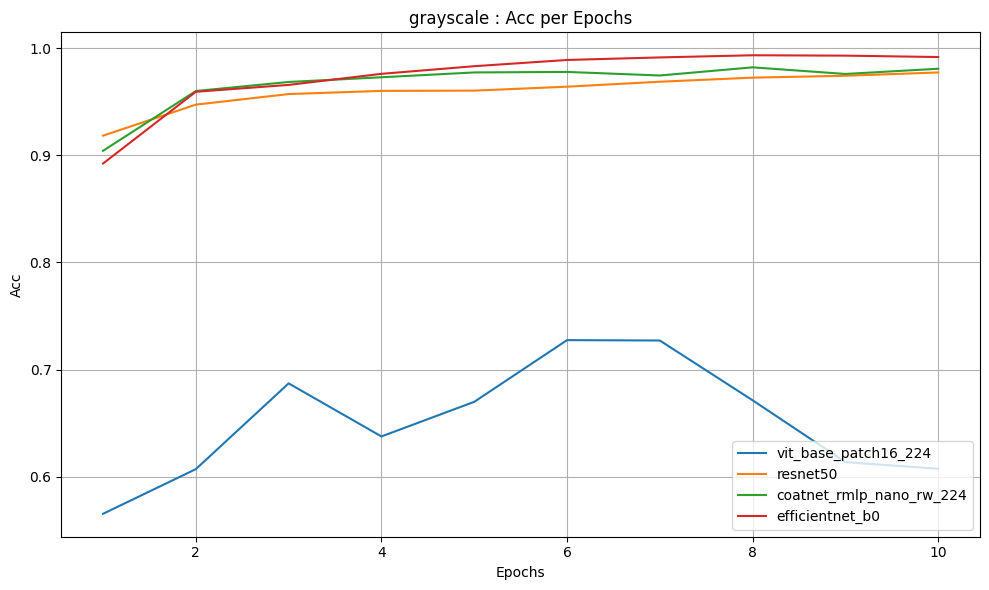

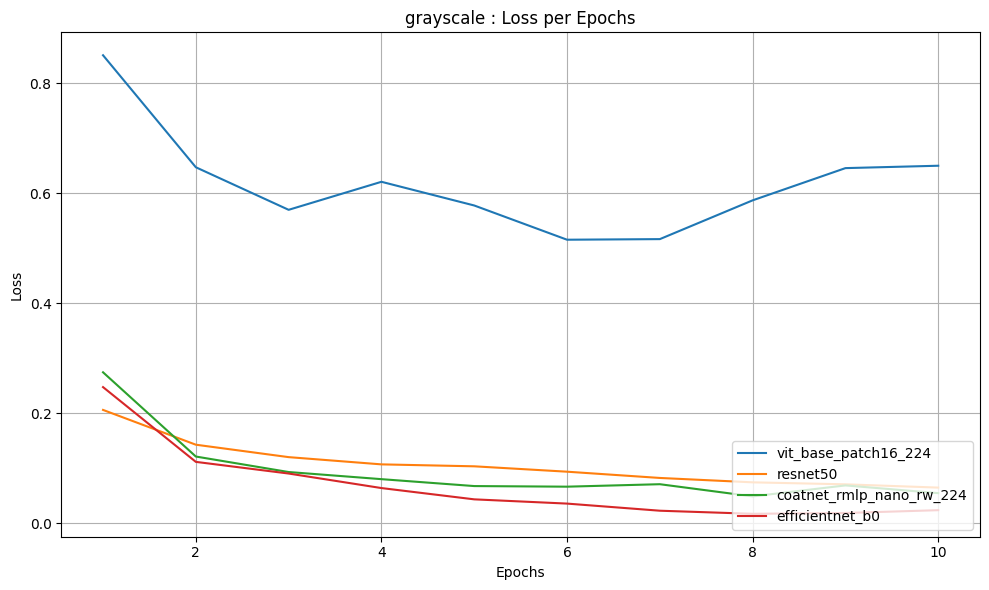

In [ ]:
# visualization_log(학습로그)
# (log데이터, 데이터셋이름, loss출력할거면 True 아니면 False)
visualization_log(acc_log, 'grayscale', if_loss=False)

visualization_log(loss_log, 'grayscale', if_loss=True)